# Do glacial velocities vary with meltwater runoff on the Greenland Ice Sheet (GIS)?
By George Lu

It is theorized that meltwater, when it penetrates to bedrock, acts as a lubricant that can accelerate the sliding of glaciers (Hoffman et al., 2011). This Jupyter notebook will examine the annual meltwater runoff calculated by a regional climate model and compare it to annual glacier velocities to see if there's any influence across the entirety of the Greenland Ice Sheet (GIS). There are some very large data sets being loaded, so I recommend using a large server. Furthermore, the velocity data has been scaled to only looking at the annual velocities between 2010-2017 rather than a larger window for the sake of containing it all to this server.

First, let's import the relevant libraries:

In [1]:
import gcsfs
import os
import pooch
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy as crt

plt.rcParams['figure.figsize'] = (12,6)

## Part 1: Importing and examining runoff data
Now, let's import daily runoff data from LDEO Glaciology Google Cloud Storage. This is simulated data from Modèle Atmosphérique Régional (MAR), version 3.5.2 that reconstructs the regional climate on the GIS (Fettweis et al., 2017). I will use years 2010-2017 to correspond to the annual velocity data. Loading it in takes some time.

In [2]:
fs = gcsfs.GCSFileSystem(project='pangeo-integration-te-3eea', mode='ab', cache_timeout = 0)
NC_list = [f'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-201{i}.nc' for i in range(0,8)]

NC_urls = ['https://storage.googleapis.com/' + NC + '#mode=bytes' for NC in NC_list] 
ds_mar = xr.open_mfdataset(NC_urls, engine='netcdf4', concat_dim='TIME')
print(f"The total size of ds_mar is {ds_mar.nbytes/1e9} gigabytes")
ds_mar

The total size of ds_mar is 13.53106123 gigabytes


<xarray.Dataset>
Dimensions:      (TIME: 2922, x: 76, y: 136, SECTOR: 2, SECTOR1_1: 1, ATMLAY3_3: 1, ZUVLEV: 3, bnds: 2, ZTQLEV: 4, OUTLAY: 18)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2010-01-01T12:00:00 ... 2017-12-31T12:...
  * x            (x) float32 -640.0 -620.0 -600.0 -580.0 ... 820.0 840.0 860.0
  * y            (y) float32 -3.348e+03 -3.328e+03 -3.308e+03 ... -667.9 -647.9
  * SECTOR       (SECTOR) float32 1.0 2.0
  * SECTOR1_1    (SECTOR1_1) float32 1.0
  * ATMLAY3_3    (ATMLAY3_3) float32 0.9997
  * ZUVLEV       (ZUVLEV) float32 10.0 50.0 100.0
  * ZTQLEV       (ZTQLEV) float32 2.0 10.0 50.0 100.0
  * OUTLAY       (OUTLAY) float32 0.0 0.05 0.1 0.2 0.3 ... 7.5 10.0 15.0 20.0
Dimensions without coordinates: bnds
Data variables: (12/54)
    ZUVLEV_bnds  (TIME, ZUVLEV, bnds) float32 dask.array<chunksize=(365, 3, 2), meta=np.ndarray>
    ZTQLEV_bnds  (TIME, ZTQLEV, bnds) float32 dask.array<chunksize=(365, 4, 2), meta=np.ndarray>
    OUTLAY_bnds  (TIME, OUTLAY, bnds) float32 dask.array<chunksize=(365, 18, 2), meta=np.ndarray>
    LON          (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    LAT          (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    SH           (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    ...           ...
    AL2          (TIME, SECTOR1_1, y, x) float32 dask.array<chunksize=(365, 1, 136, 76), meta=np.ndarray>
    ST2          (TIME, SECTOR1_1, y, x) float32 dask.array<chunksize=(365, 1, 136, 76), meta=np.ndarray>
    RO1          (TIME, OUTLAY, y, x) float32 dask.array<chunksize=(365, 18, 136, 76), meta=np.ndarray>
    TI1          (TIME, OUTLAY, y, x) float32 dask.array<chunksize=(365, 18, 136, 76), meta=np.ndarray>
    WA1          (TIME, OUTLAY, y, x) float32 dask.array<chunksize=(365, 18, 136, 76), meta=np.ndarray>
    crs          (TIME) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    institute:    University of Liege (Belgium)
    contact:      xavier.fettweis@uliege.be
    model:        regional climate model MAR (v3.12.0.3)
    date:         Mon Sep 27 13:59:58 CEST 2021

From above, this is a 13GB file, so let's just select the relevant variables before we compute this dataset (right now the variables are lazily loaded as dask arrays). I'm interested in the lat, lon, and RU variable, and only the ice covered sector (SECTOR=1). It would also be useful to keep the coordinates variable for plotting reference.

In [3]:
ds_mar_new = ds_mar[['LON','LAT','RU','crs']].sel(SECTOR=1)
print(f"The total size of ds_mar_new is {ds_mar_new.nbytes/1e9} gigabytes")
ds_mar_new

The total size of ds_mar_new is 0.362448654 gigabytes


<xarray.Dataset>
Dimensions:  (TIME: 2922, y: 136, x: 76)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2010-01-01T12:00:00 ... 2017-12-31T12:00:00
  * x        (x) float32 -640.0 -620.0 -600.0 -580.0 ... 800.0 820.0 840.0 860.0
  * y        (y) float32 -3.348e+03 -3.328e+03 -3.308e+03 ... -667.9 -647.9
    SECTOR   float32 1.0
Data variables:
    LON      (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    LAT      (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    RU       (TIME, y, x) float32 dask.array<chunksize=(365, 136, 76), meta=np.ndarray>
    crs      (TIME) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    institute:    University of Liege (Belgium)
    contact:      xavier.fettweis@uliege.be
    model:        regional climate model MAR (v3.12.0.3)
    date:         Mon Sep 27 13:59:58 CEST 2021

Next, let's try to resample this so each yearly chunk matches up with the years for the velocities. Looking at the velocity datafile site, we see that they're stored in periods from 07-01 to 06-30 of the following year (even though the filenames say 06-31), starting with 2010-07-01. So let's select that period of time and bring it into local memory, since ds_mar_new dataset is much smaller. This will take a bit of time to load.

In [4]:
ds_mar_2010_2017 = ds_mar_new.sel(TIME=slice('2010-07-01', '2017-06-30')).compute()
print(f"The total size of ds_mar_2010_2017 is {ds_mar_2010_2017.nbytes/1e9} gigabytes")
ds_mar_2010_2017

The total size of ds_mar_2010_2017 is 0.317173689 gigabytes


<xarray.Dataset>
Dimensions:  (TIME: 2557, y: 136, x: 76)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2010-07-01T12:00:00 ... 2017-06-30T12:00:00
  * x        (x) float32 -640.0 -620.0 -600.0 -580.0 ... 800.0 820.0 840.0 860.0
  * y        (y) float32 -3.348e+03 -3.328e+03 -3.308e+03 ... -667.9 -647.9
    SECTOR   float32 1.0
Data variables:
    LON      (TIME, y, x) float32 -55.82 -55.49 -55.16 ... 6.686 7.355 8.005
    LAT      (TIME, y, x) float32 59.26 59.3 59.33 59.36 ... 80.37 80.23 80.08
    RU       (TIME, y, x) float32 0.345 0.345 0.3451 ... 0.9029 0.8705 0.8566
    crs      (TIME) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    institute:    University of Liege (Belgium)
    contact:      xavier.fettweis@uliege.be
    model:        regional climate model MAR (v3.12.0.3)
    date:         Mon Sep 27 13:59:58 CEST 2021

Now on to some analysis. First, let's see what the average runoff across the whole ice sheet is. 

Text(0, 0.5, 'Runoff (mmWE/day)')

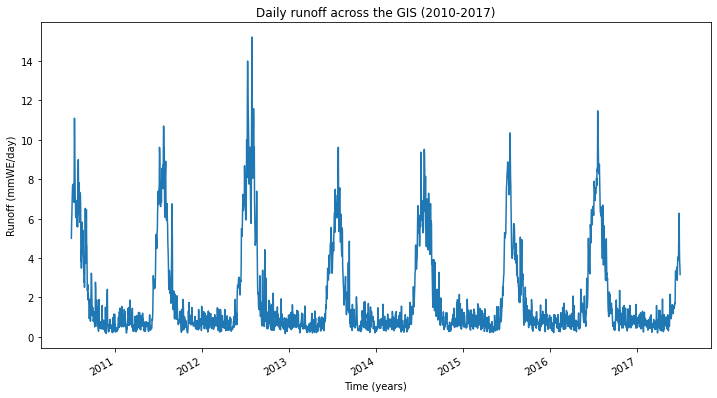

In [5]:
spa_mean_ru_raw = ds_mar_2010_2017.RU.mean(dim=['x','y'])
spa_mean_ru_raw.plot()
plt.title("Daily runoff across the GIS (2010-2017)")
plt.xlabel("Time (years)")
plt.ylabel("Runoff (mmWE/day)")

We can see that there's a very strong seasonality - most of the runoff happens in the late summer. Let's calculate the climatology and remove it to get an annual anomaly. For the annual anomaly, we'll resample it yearly with the window starting on July 1, because that'll be the start of our year for the velocity data.

Text(0.5, 1.0, 'Annual runoff anomaly')

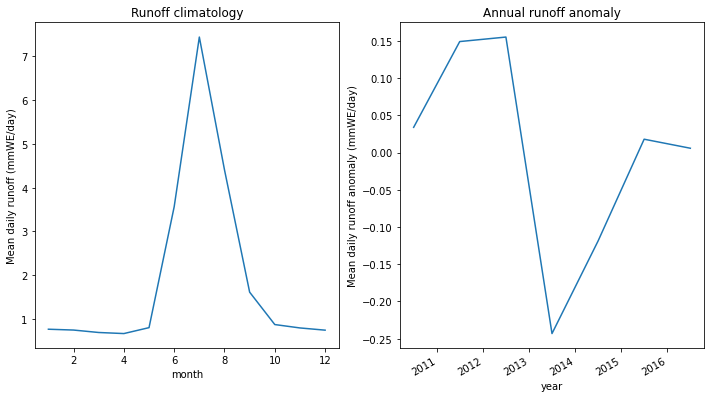

In [6]:
gb = ds_mar_2010_2017.groupby('TIME.month')
climatology = gb.mean(dim='TIME')
anomaly = gb-climatology
anomaly_resampled = anomaly.resample(TIME='AS-JUL').mean()
fig, axes = plt.subplots(ncols = 2)
climatology.RU.mean(dim=['x','y']).plot(ax=axes[0])
axes[0].set_ylabel("Mean daily runoff (mmWE/day)")
axes[0].set_title("Runoff climatology")
anomaly_resampled.RU.mean(dim=['x','y']).plot(ax=axes[1])
axes[1].set_ylabel("Mean daily runoff anomaly (mmWE/day)")
axes[1].set_xlabel("year")
axes[1].set_title("Annual runoff anomaly")

Here we see the obvious seasonality in runoff, where it is a lot higher in the summers. We also see that there is some variation in mean daily runoff anomaly between the years. This anomaly will be the topic of comparison with the velocity data.

Now diverging from the spatial means, let's look at the temporal mean in each region of the GIS.

In [7]:
temp_mean_ru = ds_mar_2010_2017.mean(dim='TIME')

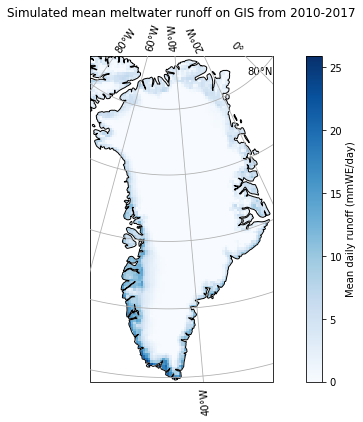

In [8]:
fig_proj = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = plt.subplots(subplot_kw={'projection': fig_proj})
ax.gridlines(draw_labels=True,zorder=4)
ax.coastlines(zorder=3)
ax.add_feature(crt.feature.OCEAN, zorder=2, edgecolor='k',color='w')
p1 = ax.pcolormesh(temp_mean_ru.LON,temp_mean_ru.LAT,temp_mean_ru.RU,transform=ccrs.PlateCarree(),
                   shading='auto',cmap='Blues',zorder=1)
cbar = fig.colorbar(p1,ax=ax)
plt.title("Simulated mean meltwater runoff on GIS from 2010-2017")
cbar.set_label("Mean daily runoff (mmWE/day)")

I applied an ocean mask to only look at runoff on the land in Greenland. As we can see it seems concentrated around the edges of the island, with highest concentrations on the Southwest.

## Part 2: Importing velocity data and doing some comparisons with runoff data
Now we import the annual velocity data from https://zenodo.org/record/4977910#.YaZSzb3ML0q. This data is derived from satellite measurements, and covers the years 2010-2017, starting in July of 2010 (Mouginot et al., 2019). Importing this data upon first run will take a while as each year is roughly 1GB of data. Also since pooch throws an error if the hash does not match (which can happen if the data didn't download properly), the below cell may need to be run a couple of times.


In [9]:
reg_dict = {
        "vel_2010-07-01_2011-06-31.nc":"md5:80ad1a3c381af185069bc032a6459745",
        "vel_2011-07-01_2012-06-31.nc":"md5:217dd7ea885b97f4eb8f81872f7835de",
        "vel_2012-07-01_2013-06-31.nc":"md5:b6744c3de16bf56f83eaf86ef688ba0c",
        "vel_2013-07-01_2014-06-31.nc":"md5:4d33e5368712d4b040e17b79fb4a3dc1",
        "vel_2014-07-01_2015-06-31.nc":"md5:777c98df25277581ca670df975e78faf",
        "vel_2015-07-01_2016-06-31.nc":"md5:a82fb87c138599d8d7e8325ba959d5ee",
        "vel_2016-07-01_2017-06-31.nc":"md5:4e73e323104c94f9d1b3e2d17935bae6",
    }
POOCH = pooch.create(
    path=pooch.os_cache("rces-project"),
    base_url = "https://zenodo.org/record/4977910/files/",
    registry= reg_dict
)
fnames = []
for key in reg_dict:
    fnames.append(POOCH.fetch(key))

Since each of these netCDFs becomes an xarray dataset 1.5GB in size, concatenating and loading all of them together will take a very long time (and actually crashed a large server whenever I tried to). Consequently, let's loop through them, lazily load them, assign a new time dimension (which they do not have), and then reduce the resolution and concatenate. We'll also add a velocity magnitude as a new variable.

For the new time dimension, we will use the start of each time window (i.e. July 1st).

In [10]:
temp = xr.open_dataset(fnames[0],chunks='auto')
ds_vel = temp.assign_coords({"TIME": ("TIME", pd.to_datetime(["2010-07-01"]))})
for i in range(1,7):
    temp = xr.open_dataset(fnames[i],chunks='auto').assign_coords({"TIME": ("TIME", pd.to_datetime([f"201{i}-07-01"]))})
    ds_vel = xr.concat([ds_vel,temp],dim="TIME")
    
ds_vel_new = ds_vel.assign(SPEED=lambda ds_vel: np.sqrt(ds_vel.VX**2 + ds_vel.VY**2))
print(f"The total size of ds_vel_new is {ds_vel_new.nbytes/1e9} gigabytes")
ds_vel_new

The total size of ds_vel_new is 15.101998127 gigabytes


<xarray.Dataset>
Dimensions:       (TIME: 7, x: 10018, y: 17946)
Coordinates:
  * x             (x) float64 -6.38e+05 -6.378e+05 ... 8.644e+05 8.646e+05
  * y             (y) float64 -6.576e+05 -6.578e+05 ... -3.349e+06 -3.349e+06
  * TIME          (TIME) datetime64[ns] 2010-07-01 2011-07-01 ... 2016-07-01
Data variables:
    coord_system  (TIME) |S1 b'' b'' b'' b'' b'' b'' b''
    VX            (TIME, y, x) float32 dask.array<chunksize=(1, 5982, 5009), meta=np.ndarray>
    VY            (TIME, y, x) float32 dask.array<chunksize=(1, 5982, 5009), meta=np.ndarray>
    SPEED         (TIME, y, x) float32 dask.array<chunksize=(1, 5982, 5009), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_final.t.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs_UC-Irvine
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use

Like in Part 1, let's do our sanity check by looking at the mean velocity plot. Let's plot them on the same plot as our runoff anomaly. 

In [11]:
# Try calculating mean velocities - will take time
spa_mean_vel = ds_vel_new.mean(dim=['x','y']).compute()

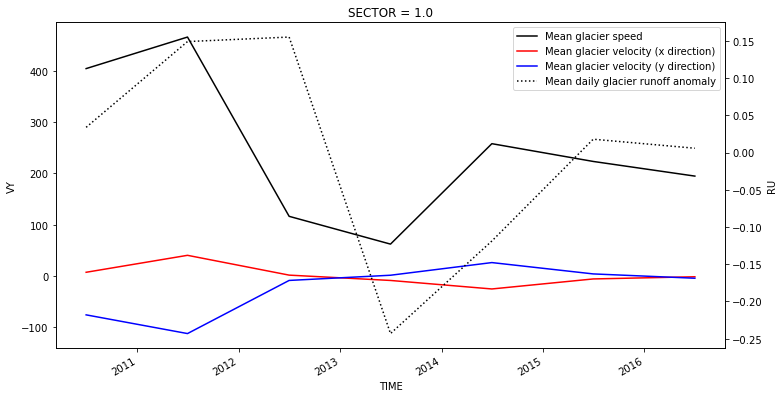

In [12]:
fig,ax1 = plt.subplots()
v = spa_mean_vel.SPEED.plot(ax=ax1,color='k',label="Mean glacier speed")
vx = spa_mean_vel.VX.plot(ax=ax1,color='r',label="Mean glacier velocity (x direction)")
vy = spa_mean_vel.VY.plot(ax=ax1,color='b',label="Mean glacier velocity (y direction)")
ax2=ax1.twinx()
ru = anomaly_resampled.RU.mean(dim=['x','y']).plot(ax=ax2,linestyle='dotted',color='k',label="Mean daily glacier runoff anomaly")
to_label = v+vx+vy+ru
labels = [l.get_label() for l in to_label]
ax1.legend(to_label,labels)

Looks like there's a bit of correlation with velocity magnitude, though it looks like the runoff lags behind the speed. This could just be a result of a small time window so no actual trend is detected. Likewise, let's take a quick look at the temporal mean over all of Greenland. This is where we'll perform our coarsening, which will take some time. This could also explain the much smaller means for vx and vy, probably because we're averaging both negative and positive values in those instances. We'll be able to see those negative and positive values in the next set of plots.

In [13]:
# Coarsen to about the same resolution as runoff data and interpolate to same coordinate system as runoff data
ds_vel_coarse = ds_vel_new.coarsen(x=133,y=133, boundary='pad').mean().compute()
temp_mean_speed = ds_vel_coarse.SPEED.mean(dim='TIME').interp(x=1000*temp_mean_ru.x,y=1000*temp_mean_ru.y)
temp_mean_vx = ds_vel_coarse.VX.mean(dim='TIME').interp(x=1000*temp_mean_ru.x,y=1000*temp_mean_ru.y)
temp_mean_vy = ds_vel_coarse.VY.mean(dim='TIME').interp(x=1000*temp_mean_ru.x,y=1000*temp_mean_ru.y)

Text(0.5, 1.0, 'Mean GIS velocities (2010-2017)')

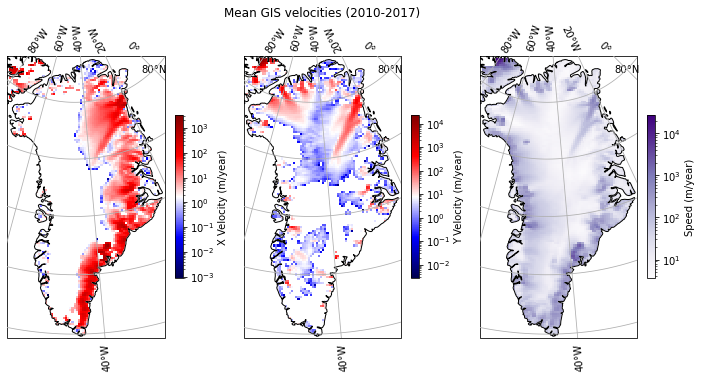

In [14]:
fig_proj = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, axes = plt.subplots(ncols = 3, subplot_kw={'projection': fig_proj})
for ax in axes:
    ax.gridlines(draw_labels=True,zorder=4)
    ax.coastlines(zorder=3)
    # Limit to ice on land
    ax.add_feature(crt.feature.OCEAN, zorder=2, edgecolor='k',color='w')
# Use same lat/lon coordinates as runoff data since we interpolated to their x/y
# Furthermore, this dataset did not come with lat/long values for cartopy to use
p0 = axes[0].pcolormesh(temp_mean_ru.LON,temp_mean_ru.LAT,temp_mean_vx,transform=ccrs.PlateCarree(),
                   shading='auto',cmap='seismic',zorder=1,norm=LogNorm())
p1 = axes[1].pcolormesh(temp_mean_ru.LON,temp_mean_ru.LAT,temp_mean_vy,transform=ccrs.PlateCarree(),
                   shading='auto',cmap='seismic',zorder=1,norm=LogNorm())
p2 = axes[2].pcolormesh(temp_mean_ru.LON,temp_mean_ru.LAT,temp_mean_speed,transform=ccrs.PlateCarree(),
                   shading='auto',cmap='Purples',zorder=1,norm=LogNorm())
cbar0 = fig.colorbar(p0,ax=axes[0],shrink=0.5)
cbar0.set_label("X Velocity (m/year)")
cbar1 = fig.colorbar(p1,ax=axes[1],shrink=0.5)
cbar1.set_label("Y Velocity (m/year)")
cbar2 = fig.colorbar(p2,ax=axes[2],shrink=0.5)
cbar2.set_label("Speed (m/year)")
axes[1].set_title("Mean GIS velocities (2010-2017)")

We see that overall, like the runoff, the largest velocity magnitudes are concentrated at the edges of Greenland. 

## Part 3: Correlation analysis
First, let's look at a cross correlation between our resampled runoff anomaly data and our coarsened velocity data. We'll look at their correlation over time (so we'll see a 2D cross correlation over space). 

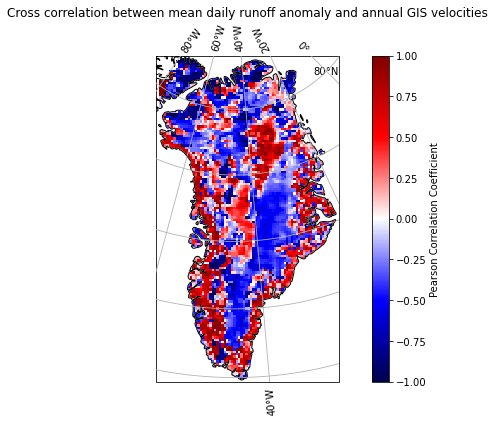

In [15]:
runoff_array = anomaly_resampled.RU
speed_array = ds_vel_coarse.SPEED.interp(x=1000*temp_mean_ru.x,y=1000*temp_mean_ru.y)
corr = xr.corr(runoff_array,speed_array,dim="TIME")

fig_proj = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = plt.subplots(subplot_kw={'projection': fig_proj})
ax.gridlines(draw_labels=True,zorder=4)
ax.coastlines(zorder=3)
ax.add_feature(crt.feature.OCEAN, zorder=2, edgecolor='k',color='w')
p1 = ax.pcolormesh(temp_mean_ru.LON,temp_mean_ru.LAT,corr,transform=ccrs.PlateCarree(),
                   shading='auto',cmap='seismic',zorder=1)
cbar = fig.colorbar(p1,ax=ax)
plt.title("Cross correlation between mean daily runoff anomaly and annual GIS velocities")
cbar.set_label("Pearson Correlation Coefficient")


So we see that in the lower elevation regions closer to the ocean, there is a very strong correlation between runoff and velocity. On the otherhand, on certain regions further inland, it seems that there is an inverse correlation. Our main takeaway from this plot is that over the period of 2010-2017, the areas on the coast that experienced higher runoffs most likely also experienced faster glacier speeds.

## Areas for further analysis (outside of this project's scope)
This project had time and space constraints, but offers some basic insights as to how surface meltwater runoff may be correlated to ice sheet velocities. However, for more rigorous analysis, higher resolution datasets (both temporally and spatially) could be utilized to get a more precise correlation. In our case, we were limited in temporal resolution for the velocity data, but limited in spatial resolution for the runoff data. Further advanced analysis could probably account for other factors that could influence both runoff and velocity, such as surface temperature or bedrock elevation. Overall, even though this project has helped visualize potential correlations between surface runoff and ice sheet velocity, much more data needs to be considered to evaluate further connections.

## References


Fettweis, X., Box, J. E., Agosta, C., Amory, C., Kittel, C., Lang, C., van As, D., Machguth, H., and Gallée, H. (2017), Reconstructions of the 1900–2015 Greenland ice sheet surface mass balance using the regional climate MAR model, The Cryosphere, 11, 1015–1033, doi:10.5194/tc-11-1015-2017.

Hoffman, M. J., Catania, G. A., Neumann, T. A., Andrews, L. C., and Rumrill, J. A. (2011), Links between acceleration, melting, and supraglacial lake drainage of the western Greenland Ice Sheet, J. Geophys. Res., 116, F04035, doi:10.1029/2010JF001934.

Mouginot, Jeremie, Rignot, Eric, Scheuchl, Bernd, Wood, Michael, & Millan, Romain. (2019). Annual Ice Velocity of the Greenland Ice Sheet (2010-2017) [Data set]. doi:10.7280/D11H3X.